# Subject Video Rating Correlations

In [1]:
## Data management and cleaning

In [2]:
import pandas as pd
import numpy as np
import os
import scipy
import scipy.io as sio

import itertools

from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline  

In [3]:
def half_integer_round(number): return round(number * 2) / 2
def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step

In [12]:
project_filepath = "/Users/mdclark/Desktop/EmpAcc/data/behavioraldata/scanfiles/"
derivative_filepath = "/Users/mdclark/Desktop/EmpAcc/data/behavioraldata/scanfiles_derivatives/"


project_file_contents = os.listdir(project_filepath)

project_file_contents_mat = [item for item in project_file_contents if ".mat" in item]


#Get unique subject IDs (first three numbers of filename)
unique_sub_ids = [item for item in project_file_contents if 'video' in item]
unique_sub_ids = set([str.split(file, "_")[0] for file in unique_sub_ids])

unique_sub_ids = [ '145', '157', '168', '184',  '200', '214',  '219', '220', '222', '223', '229', '245', '253', '257', '263',  '267', '270', '277']
unique_sub_ids.sort(key=float)

In [13]:
# Create data frame that has all video data (per subject)

def get_video_data(sub_id, video):
    project_file_contents = os.listdir(project_filepath)
    sub_video_filenames = [item for item in project_file_contents if str(sub_id)  in item]
    sub_video_filenames = [item for item in sub_video_filenames if 'video' + str(video) + '.csv'  in item]    
    sub_video_data = []
    file = sub_video_filenames[0]


    csv_contents = pd.read_csv(project_filepath + file)
    video_data = pd.DataFrame(csv_contents)
    video_data.columns = ['second', 'rating']
    video_data['subject'] = str.split(file, "_")[0]
    video_data['video_number'] = int(float(str.split(file, "_")[2].replace('.csv', '').replace('video', '')))
    video_data['second'] = video_data['second'].apply(lambda x: half_integer_round(x))

    #ref_data = create_ref_file(sub_id, project_file_contents)
    #all_videos = pd.merge(sub_video_data, ref_data, on='video_number', how='left')
    #video_data = all_videos[all_videos['video_number'] == video]
    video_data = video_data[video_data['second'] != 0]
    

    return(video_data[['second','rating']])


In [14]:
#Plots correlations heatmap matrix

def plot_corrs(all_video_data, video):
    
    sns.set(style="white")

    # Compute the correlation matrix
    corr = all_video_data.corr()

    # Genesampling_rate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Genesampling_rate a custom diverging colormap
    #cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    #sns.heatmap(corr, mask=mask,  cmap=cmap, vmax=1, center=0,
    #            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    sns.heatmap(corr, vmax=1, center=0,
                square=True, mask=mask, linewidths=.5, cbar_kws={"shrink": .5})
    
    averge_z_correlation = calculate_aver_correlation(all_video_data)

    plt.title('Video: ' + str(video) + " , Correlation (z) " + str(averge_z_correlation))
    
    

In [15]:
#Calculate average correlation (z)

def calculate_aver_correlation(all_video_data): 
    
    corr_values = []
    
    for subject in unique_sub_ids: 
        #Get everyone else's data
        subject_data = all_video_data[subject]
        mean_data = all_video_data.loc[:, all_video_data.columns != 'second']
        mean_data = mean_data.mean(axis=1)
        
        corr_values.append([subject,subject_data.corr(mean_data)])
        
    corr_values = pd.DataFrame(corr_values)
    corr_values.columns = ['sub', 'corr']
    
    corr_values['z'] = 0.5*np.log((1+corr_values['corr'])/(1-corr_values['corr']))
    corr_values['z'] = pd.to_numeric(corr_values['z'], errors='coerce')
    corr_values = corr_values.replace([np.inf, -np.inf], np.nan)
    
    #sns.distplot(corr_values['z'].dropna())
    return(corr_values['z'].mean())
    
        

all_video_data = pd.read_csv(derivative_filepath + 'correlationdata/' + 'video_all_' + str(3) + '.csv')

calculate_aver_correlation(all_video_data)

0.5401920119795647

In [16]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Plots

###     Target  Rating and Average Participant Ratings

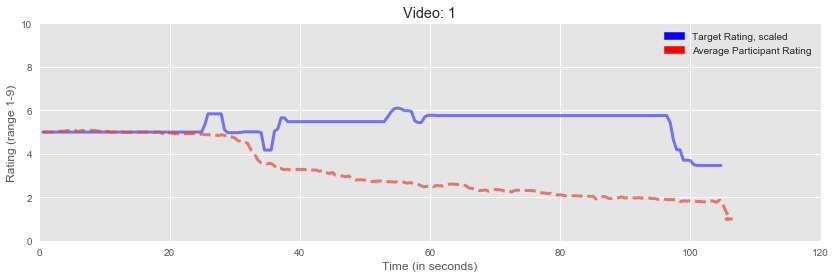

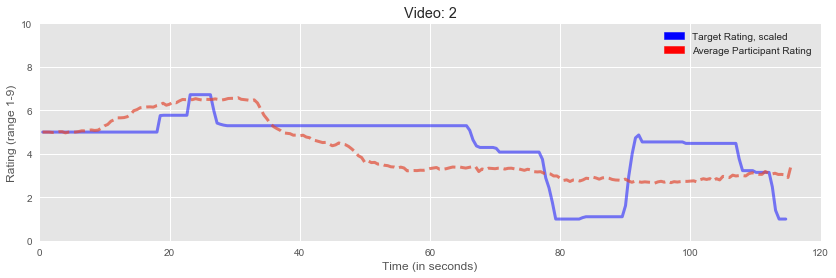

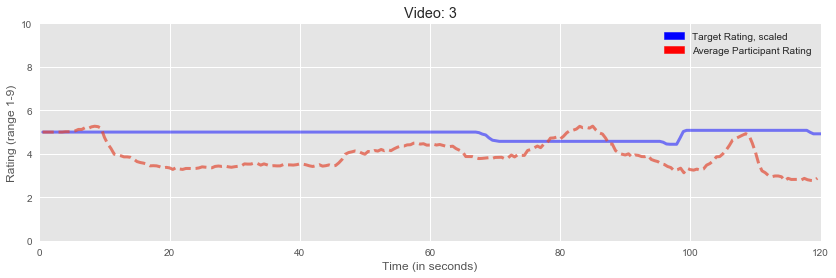

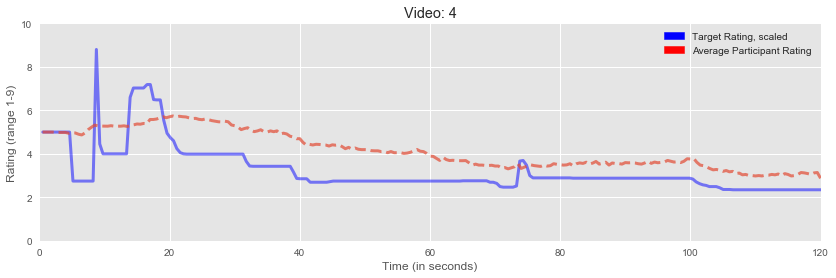

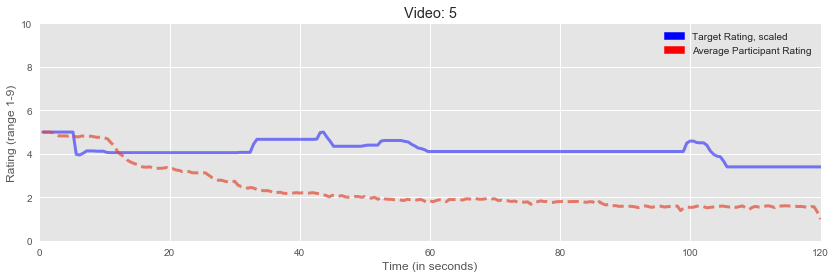

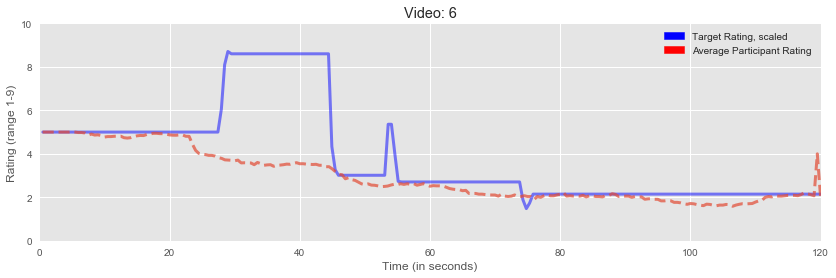

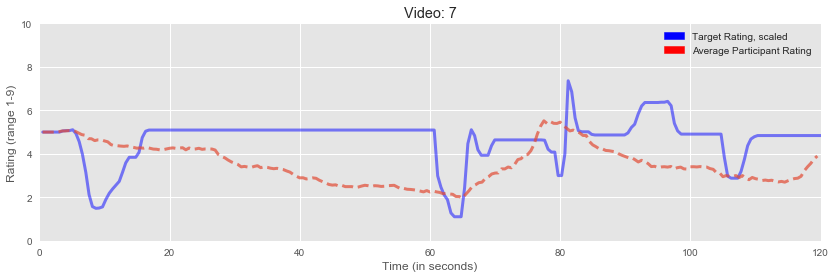

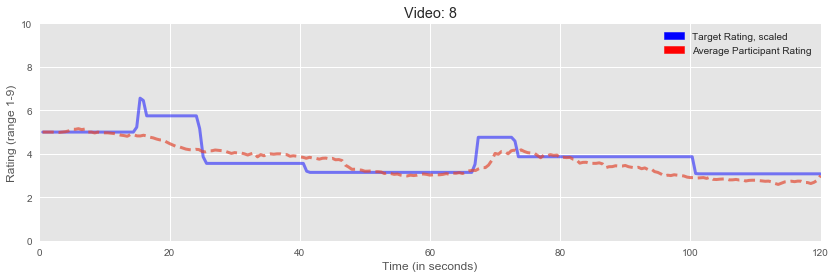

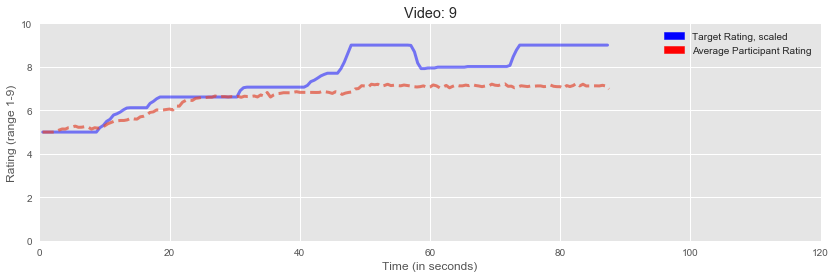

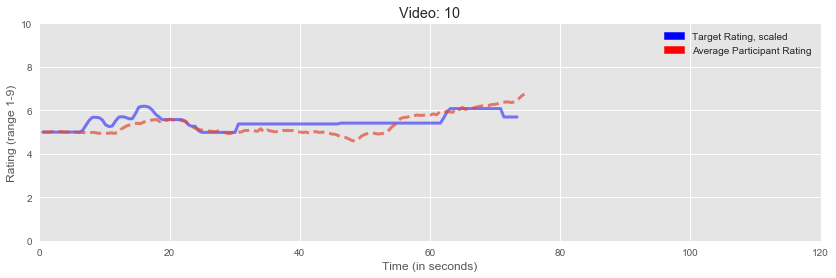

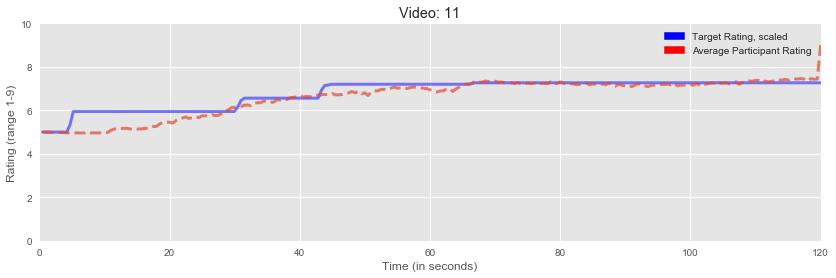

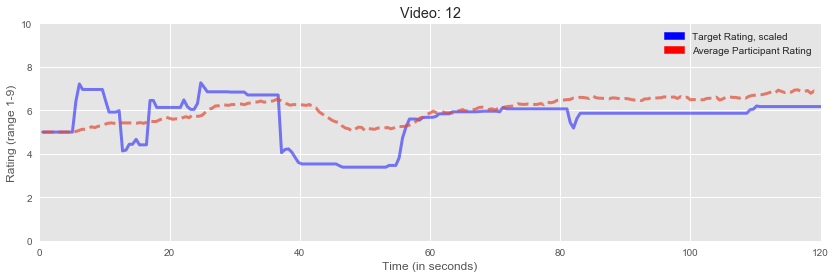

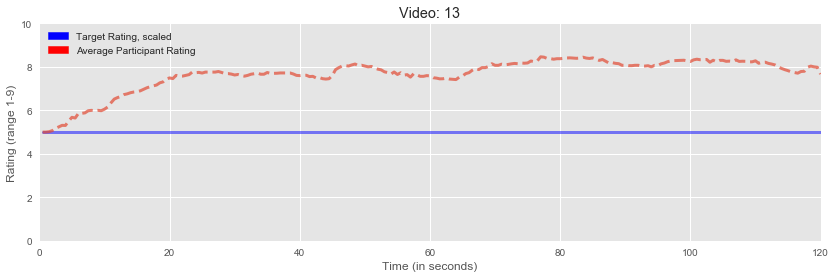

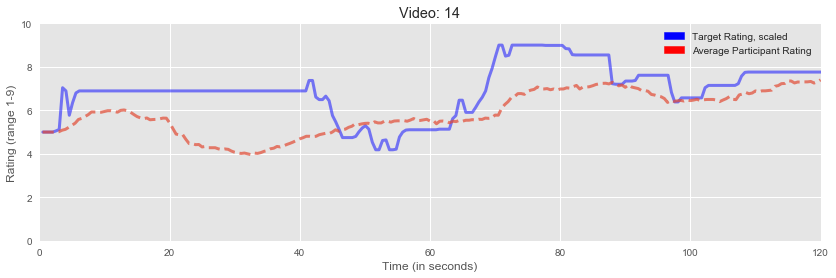

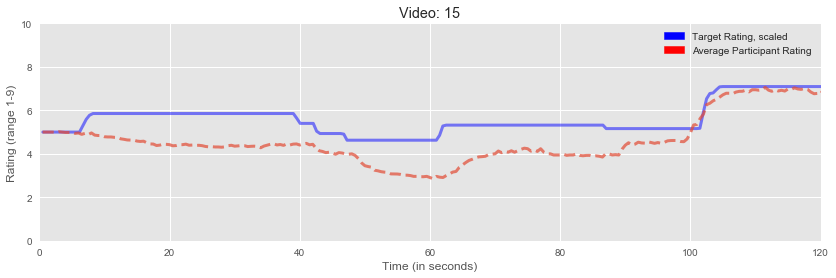

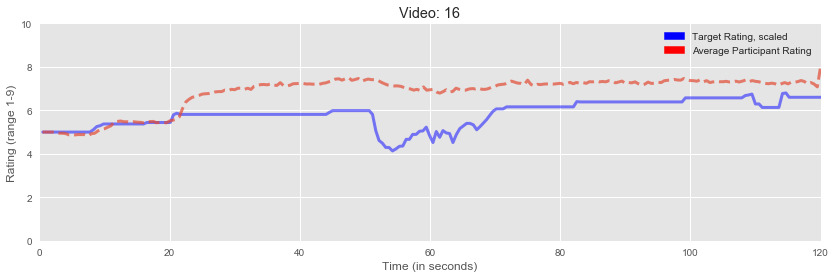

In [17]:
for video in range(1, 17): 
    all_video_data = pd.read_csv(derivative_filepath + 'correlationdata/' + 'video_all_' + str(video) + '.csv')
    target_data = pd.read_csv(project_filepath + '100_01_video' + str(video) + '.csv')

    target_data['rating_scaled'] = (((target_data[' rating'] - 0) * (9 - 1)) / (100 - 0)) + 1


    # Plot target
    
    x = target_data['time']
    y = target_data['rating_scaled']
    
    plt.figure(figsize=(14,4))
    plt.style.use('ggplot')

    plt.title("Video: " + str(video))
    plt.ylim(0,10)
    plt.ylabel('Rating (range 1-9)')
    plt.xlim(0,120)
    plt.xlabel('Time (in seconds)')

    plt.plot(x, y,'b', linewidth=3,  alpha=.5);



    
    # Plot data
    x = all_video_data['second']
    y = all_video_data.drop(['second'], axis=1).mean(axis=1)
    
    
    legend_blue = mpatches.Patch(color='blue', label='Target Rating, scaled')
    legend_red = mpatches.Patch(color='red', label='Average Participant Rating')
    plt.legend(handles=[legend_blue, legend_red])    
    
    plt.plot(x, y, '--', linewidth=3, alpha=.7);
    

### Matrix Plots of Participant Ratings and Time Course of Ratings

First plot is a matrix of correlations between participants. 
Second plot is each participant's ratings by time. 

/Users/mdclark/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


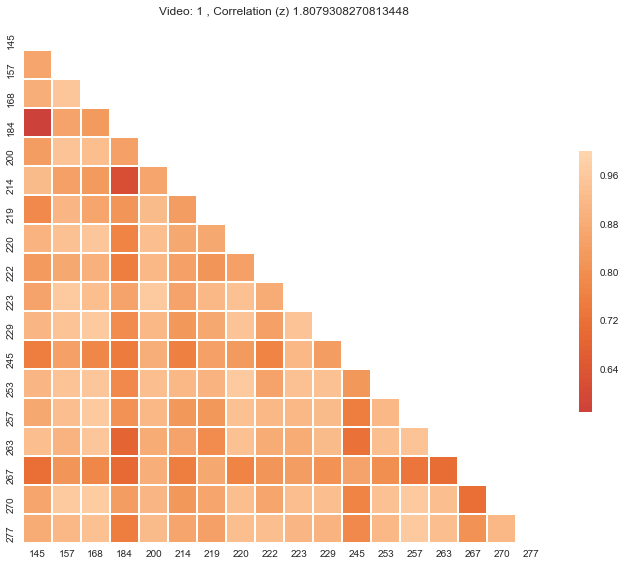

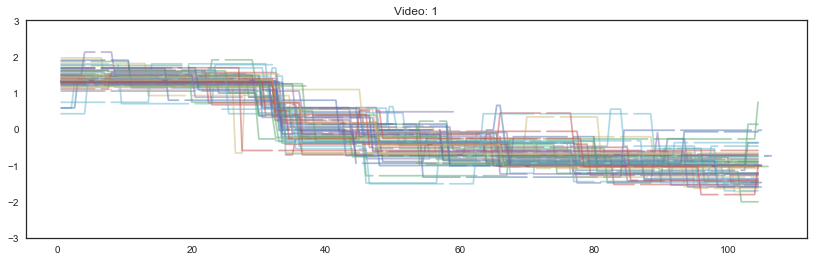

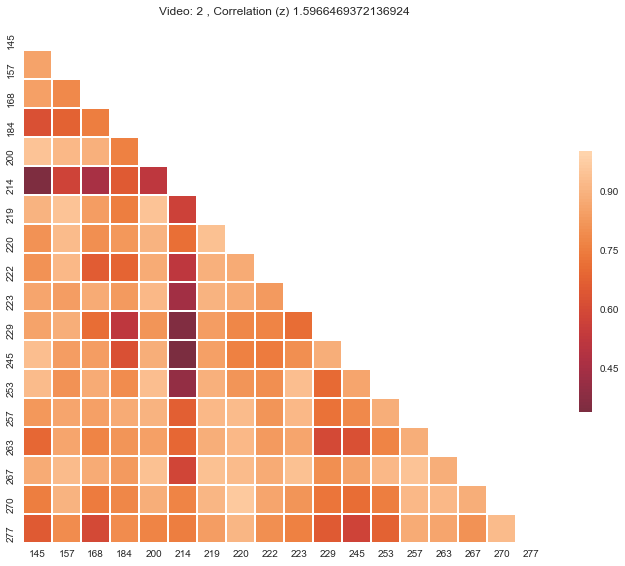

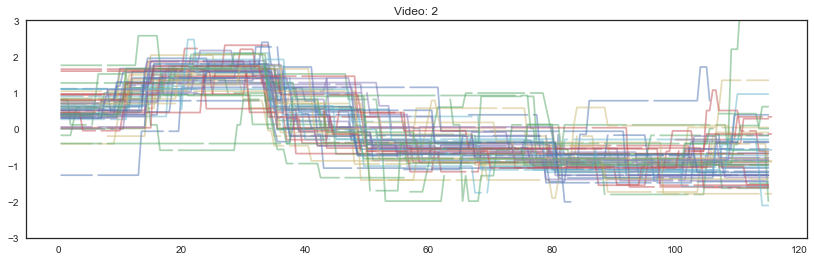

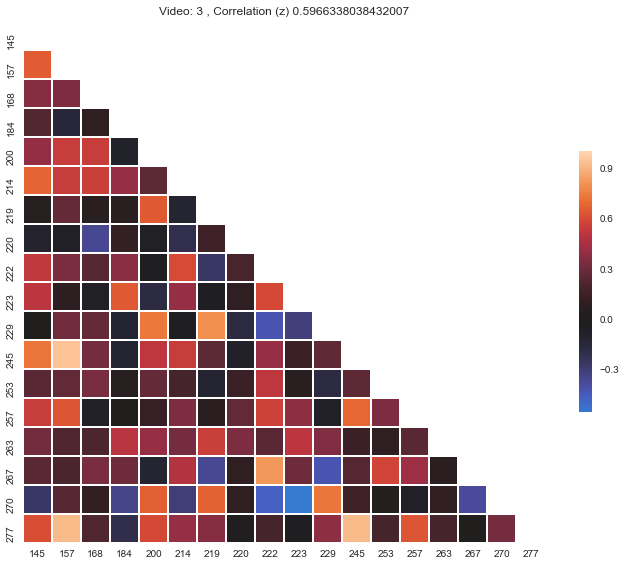

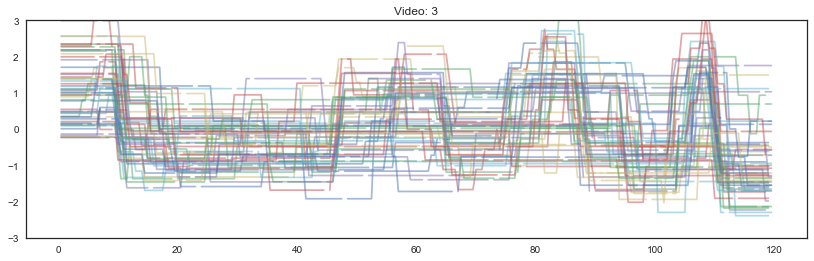

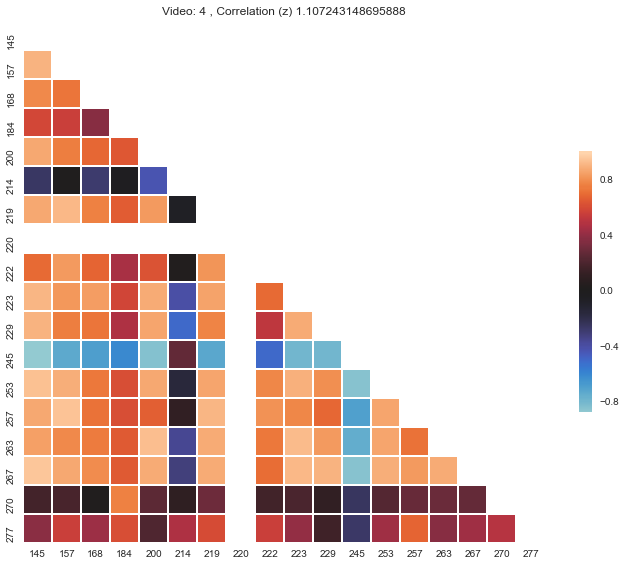

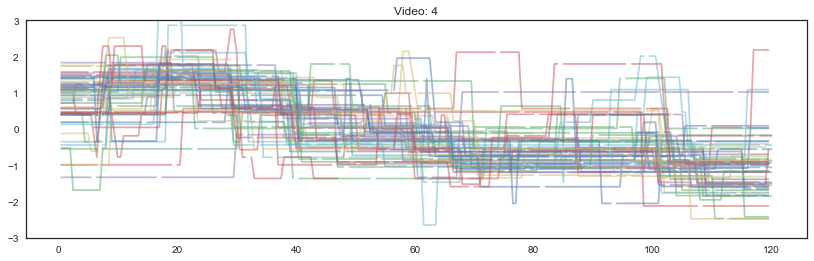

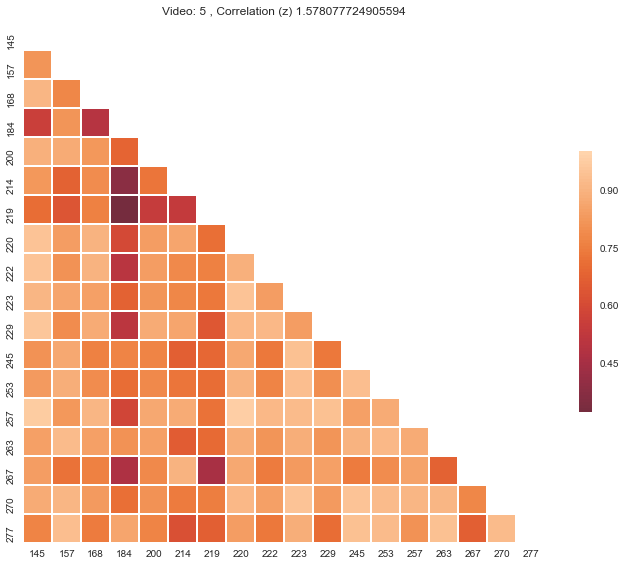

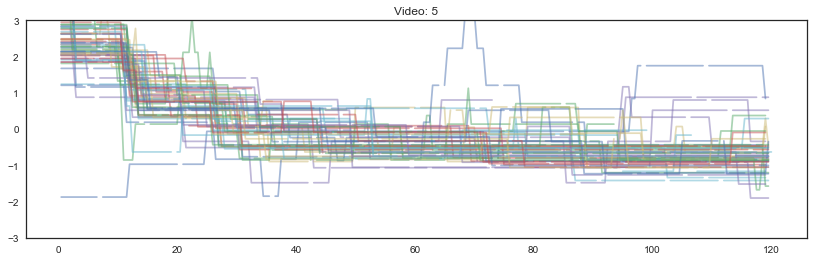

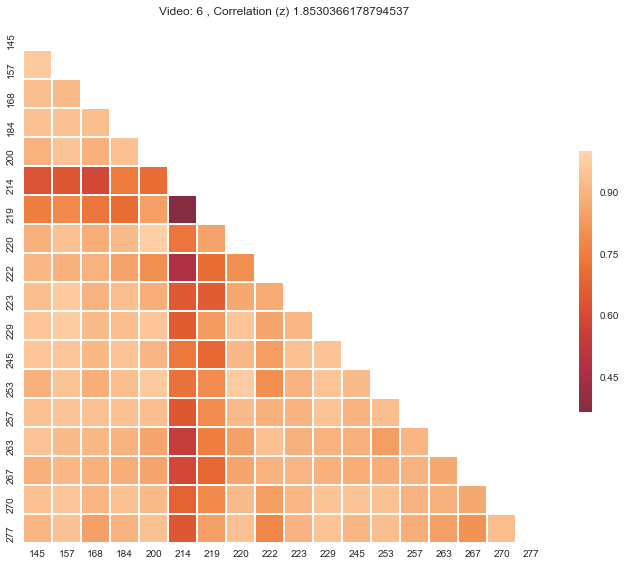

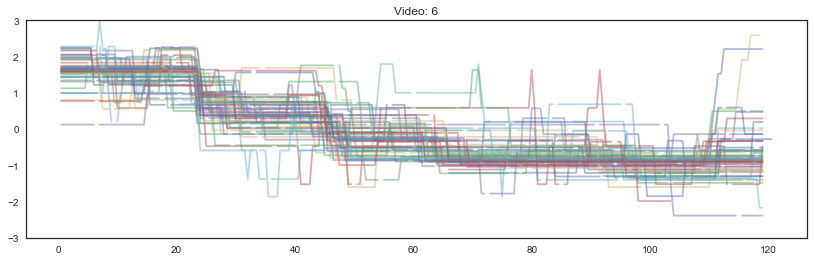

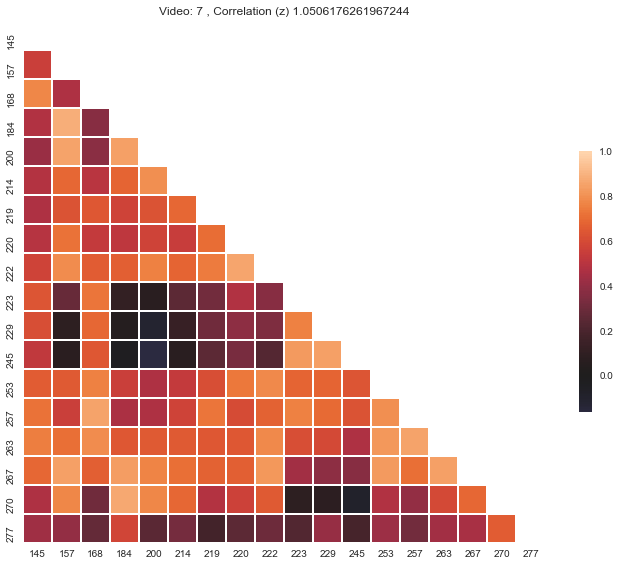

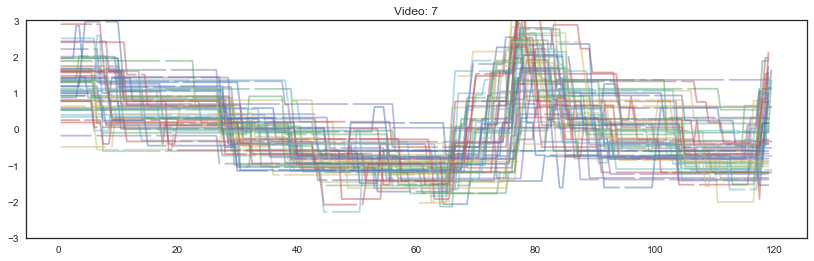

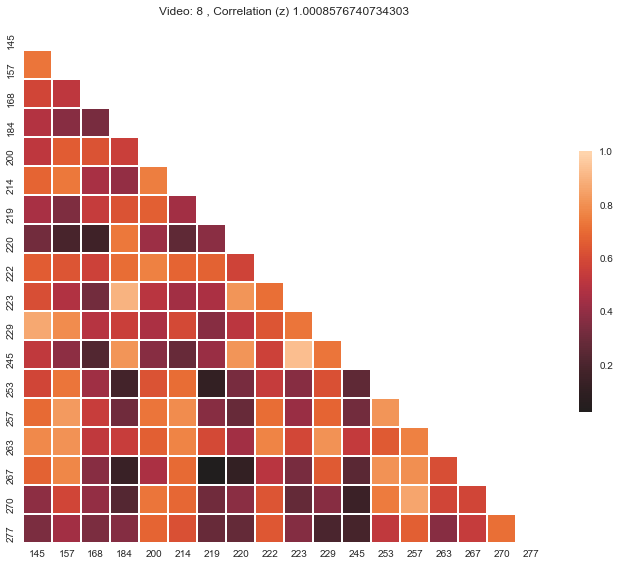

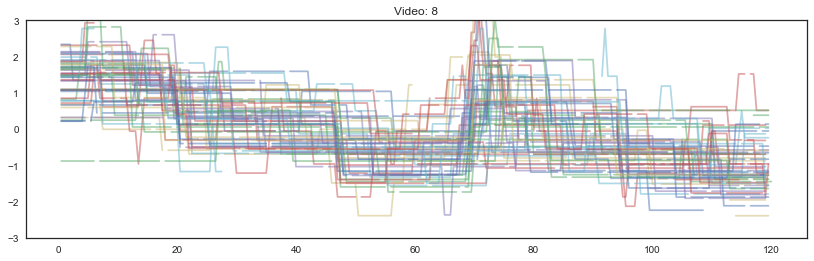

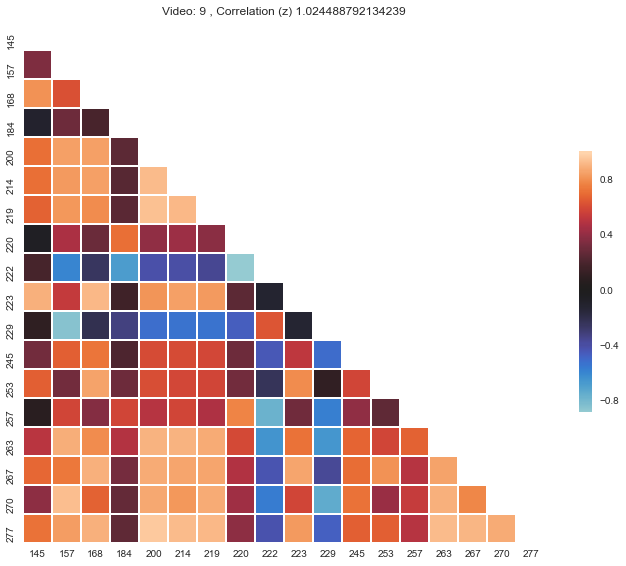

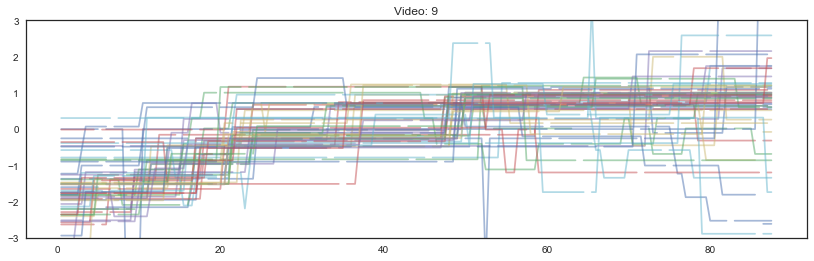

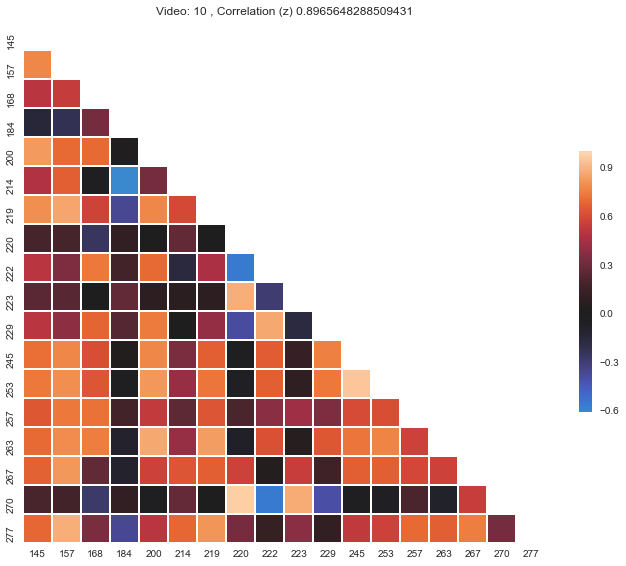

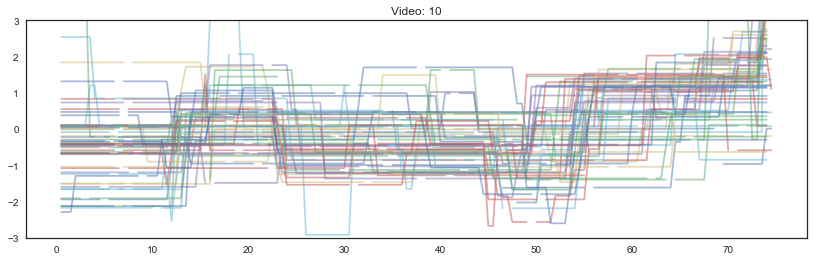

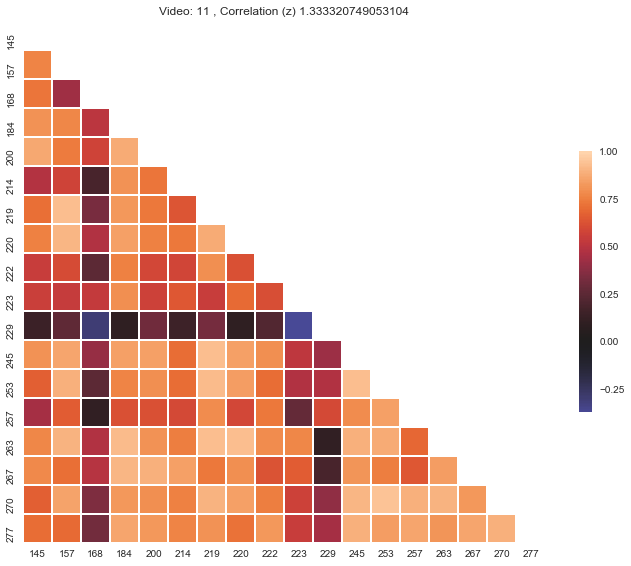

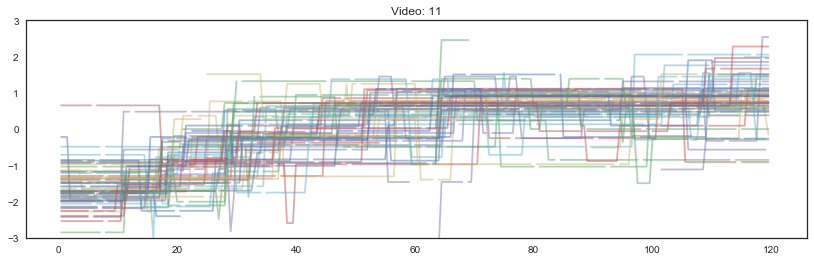

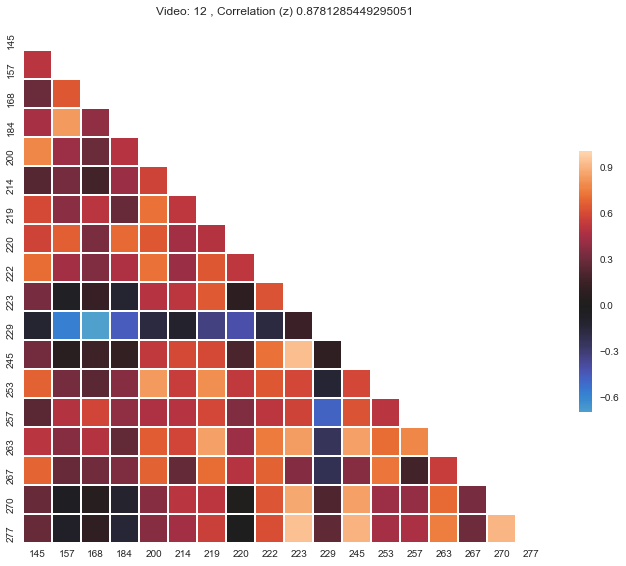

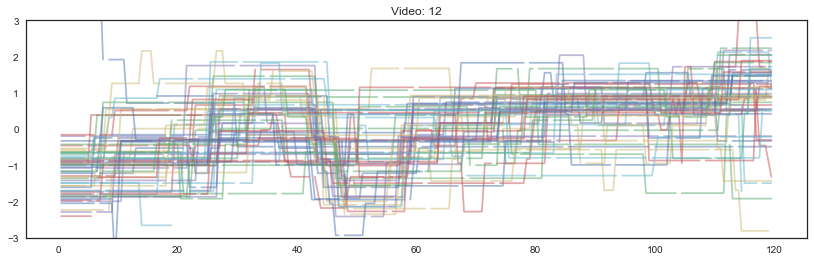

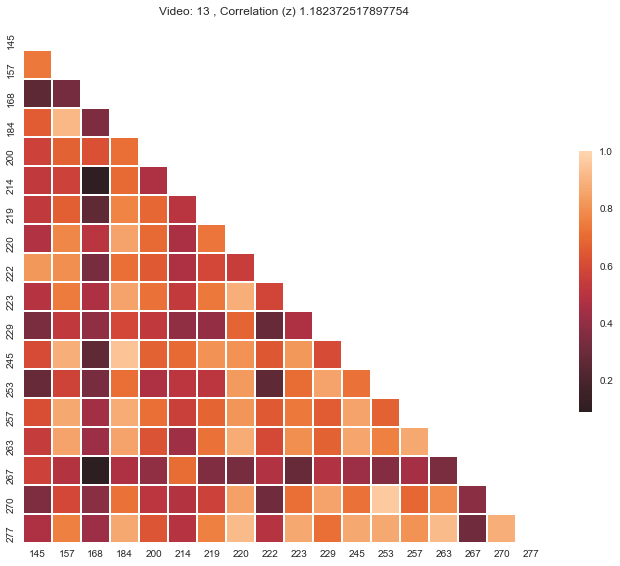

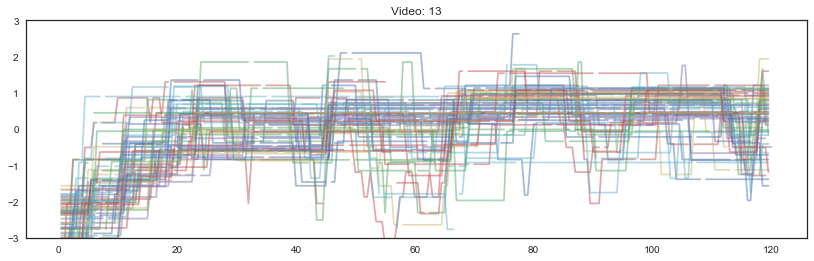

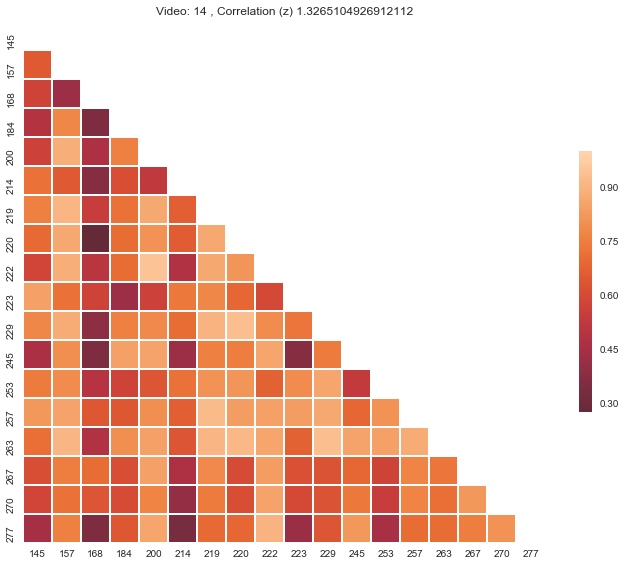

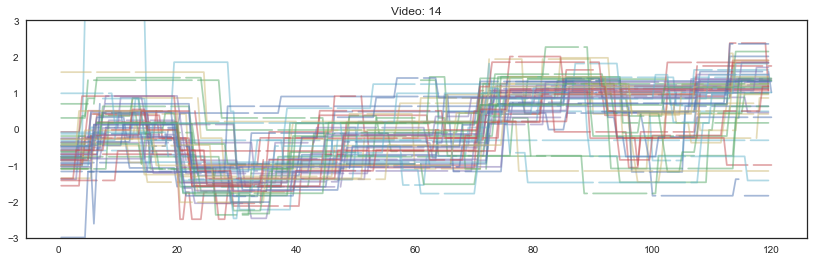

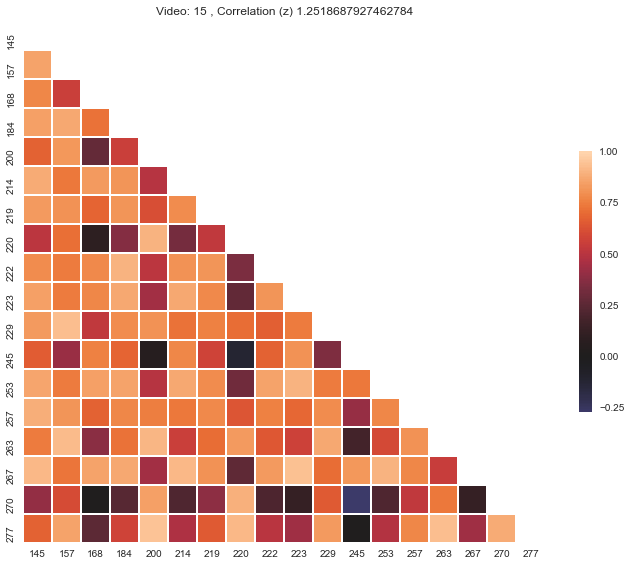

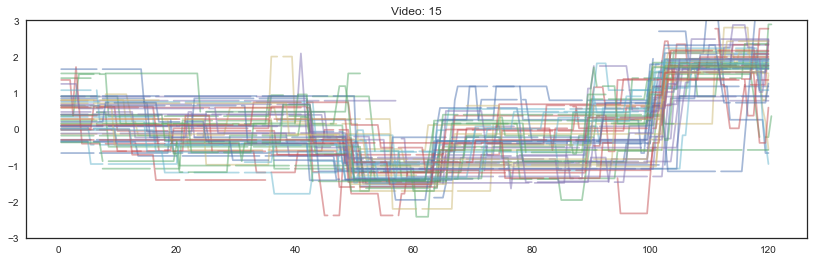

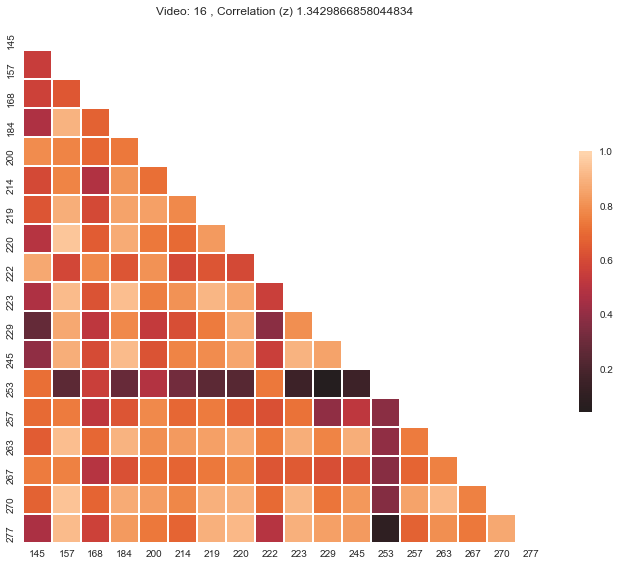

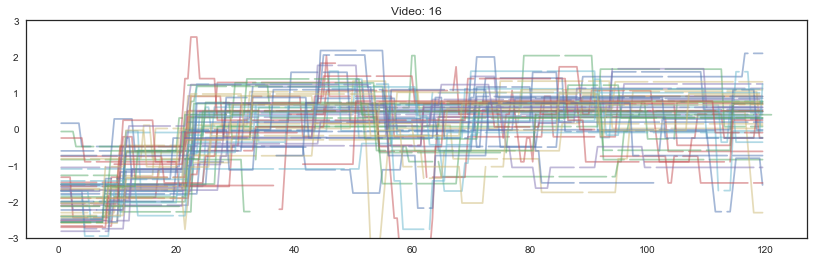

In [18]:
z_correlations = []
for video in range(1, 17): 
    all_video_data = pd.read_csv(derivative_filepath + 'correlationdata/' + 'video_all_' + str(video) + '.csv')
    all_video_data_dropped = all_video_data.drop(['second'], axis=1)
    z_correlations.append([video, calculate_aver_correlation(all_video_data_dropped)])

    
    calculate_aver_correlation(all_video_data_dropped)
        
    # Plot correlations
    all_video_data_subs = all_video_data[unique_sub_ids]
    plot_corrs(all_video_data_subs, video)
    plt.tight_layout(pad=4)
        
    # Plot data
    x = all_video_data['second']
    y = all_video_data.drop(['second'], axis=1)

    # Z-score ratings by participant
    cols = list(y.columns)
    for col in cols:
        col_zscore = col
        y[col_zscore] = (y[col] - y[col].mean())/y[col].std(ddof=0)
    
    

    plt.figure(figsize=(14,4))
    plt.ylim(-3,3)
    plt.title('Video: ' + str(video) )
    plt.plot(x, y, alpha=.5);



## Sliding Window Correlations (30 second window)

In [ ]:
#Sliding window

for video in range(1, 17): 
    
    #Initialize
    z_correlations = []
    z_ratings = []
    window = 15 
    all_video_data = pd.read_csv(derivative_filepath + 'correlationdata/' + 'video_all_' + str(video) + '.csv')
        
    #Z score participant ratings (columns)
    y = all_video_data.drop(['second'], axis=1)
    cols = list(y.columns)
    for col in cols:
        col_zscore = col
        y[col_zscore] = (y[col] - y[col].mean())/y[col].std(ddof=0)
        

        
    # Get Z scored correlations and ratings    
    for timepoint in range(window, int(all_video_data['second'].max()-window), 1):
        cropped_video_data = all_video_data[(all_video_data['second'] >= timepoint - window) &\
                                            (all_video_data['second'] <= timepoint + window) ] 
        cropped_video_data_dropped = cropped_video_data.drop(['second'], axis=1)
        
        z_correlations.append([video, timepoint, calculate_aver_correlation(cropped_video_data_dropped)])
        
        z_ratings.append([video, timepoint, y.ix[timepoint-window:timepoint+window,:].stack().mean() ]); 
       
    z_correlations = pd.DataFrame(z_correlations)    
    average_z_correlation = calculate_aver_correlation(all_video_data.drop(['second'], axis=1))
    z_ratings = pd.DataFrame(z_ratings)    
             
        
    # Plot data
    x = z_correlations[1]
    y = z_correlations[2]
    plt.figure(figsize=(14,4))
    plt.xlim(0,120)
    plt.ylim(-.2,1.5)
    plt.title('Video: ' + str(video) + " Z Correlation: " + str(average_z_correlation))
    plt.plot(x, y, alpha=.5);
    

    # Plot data
    x = all_video_data['second']
    y = all_video_data.drop(['second'], axis=1)
    
    cols = list(y.columns)
    for col in cols:
        col_zscore = col
        y[col_zscore] = (y[col] - y[col].mean())/y[col].std(ddof=0)
    
    
    plt.figure(figsize=(14,4))
    plt.xlim(0,120)
    plt.ylim(-3,3)
    plt.title('Video: ' + str(video))
    plt.plot(x, y, alpha=.5);


    
    
print("Z Correlations w/ sampling sampling_rate of 10 seconds")

### Z scored average correlations and BEQ (expressivity)

In [ ]:
BEQ  = pd.read_csv('/Users/mdclark/Desktop/EmpAcc/data/behavioraldata/BEQ.csv')
BEQ = BEQ.merge(pd.DataFrame(z_correlations, columns=['videoNumber', 'z_corr']))


sns.lmplot('BEQ_n', 'z_corr', col='rateSelfOther', fit_reg = True, data=BEQ)
sns.lmplot('BEQ_p', 'z_corr', col='rateSelfOther', data=BEQ)#
sns.lmplot('BEQ_total', 'z_corr', col='rateSelfOther', data=BEQ)#

BEQ['BEQ_np'] = BEQ[['BEQ_n', 'BEQ_p']].mean(axis=1)
sns.lmplot('BEQ_np', 'z_corr', col='rateSelfOther', data=BEQ)

import numpy
numpy.corrcoef(BEQ['BEQ_np'], BEQ['z_corr'])



import scipy
scipy.stats.pearsonr(BEQ_negative['BEQ_n'], BEQ_negative['z_corr'])



In [ ]:
IRI  = pd.read_csv('/Users/mdclark/Desktop/EmpAcc/data/behavioraldata/IRI.csv')
IRI = IRI.merge(pd.DataFrame(z_correlations, columns=['videoNumber', 'z_corr']))


sns.lmplot('IRI_PD', 'z_corr', fit_reg = True, data=IRI)
sns.lmplot('IRI_EC', 'z_corr', data=IRI)#
sns.lmplot('IRI_PT', 'z_corr', data=IRI)#



In [ ]:
for video in range(1, 17): 
    z_correlations = []
    z_ratings = []
    sampling_rate = 20
    all_video_data = pd.read_csv(derivative_filepath + 'correlationdata/' + 'video_all_' + str(video) + '.csv')
        
    #Z score participant ratings    
    y = all_video_data.drop(['second'], axis=1)
    cols = list(y.columns)
    for col in cols:
        col_zscore = col
        y[col_zscore] = (y[col] - y[col].mean())/y[col].std(ddof=0)
        
    # Get Z scored correlations and ratings    
    for timepoint in range(10, 130, sampling_rate):
        cropped_video_data = all_video_data[(all_video_data['second'] >= timepoint - sampling_rate) & (all_video_data['second'] < timepoint)] 
        cropped_video_data_dropped = cropped_video_data.drop(['second'], axis=1)
        
        z_correlations.append([video, timepoint, calculate_aver_correlation(cropped_video_data_dropped)])
        
        z_ratings.append([video, timepoint, y.ix[timepoint-sampling_rate:timepoint,:].stack().mean() ]); 
       
    z_correlations = pd.DataFrame(z_correlations)    
    average_z_correlation = calculate_aver_correlation(all_video_data.drop(['second'], axis=1))
    z_ratings = pd.DataFrame(z_ratings)    
                   
    
    all_z = pd.merge(z_ratings, z_correlations, on=1)
    sns.lmplot('2_x', '2_y', data=all_z)
    
    
print("Z Correlations w/ sampling sampling_rate of 10 seconds")